# **PRÁCTICA 3:  Machine Learning - SVM para clasificación**
### Universitat de València, Escola Tecnica Superior d'Enginyeria
### Elena Marrero Castellano | 3ª curso del Grado Ciencia de Datos

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.svm import SVC
from sklearn.datasets import make_moons, load_iris
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.decomposition import PCA

## Usaremos un ejemplo "juguete" para ilustrar cómo funciona la SVM y cómo influyen los hiperparámetros

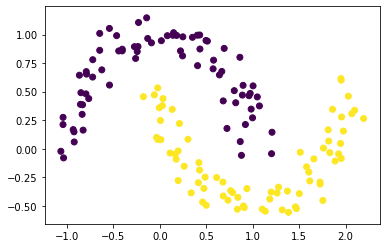

In [ ]:
# Generamos los datos, los representamos
X, y = make_moons(n_samples=150, noise=0.1) # le hemos metido ruido porque es más facil de resolver
plt.scatter(X[:,0], X[:,1], c=y)
# Dividimos ya desde el principio nuestros datos en entrenamiento y test
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=1/3)

## Normalización de los datos
El algoritmo de entrenamiento de las SVM es bastante sensible al rango de los datos, pudiendo dar problemas de estabilidad en caso de que los datos de entrada (las $X$) no estén debidamente normalizados.

Para evitar dichos problemas y mejorar los resultados el primer paso que debemos dar al trabajar con SVMs es normalizar los datos. Las normalizaciones que mejores resultados obtienen son escalar los datos entre 0 y 1 (o entre -1 y 1), o normalizarlos restando la media y dividiendo por la desviación estándar.

Para este primer ejemplo "juguete" con el que vamos a empezar **no** vamos a realizar este paso dado que los datos ya se encuentran en una escala de valores apropiada (prácticamente entre -1 y 1). No obstante tened en cuenta que lo normal será normalizar como primer paso.

Para más información sobre la SVM en general y sobre este tema de escalado en particular os aconsejamos leer este documento: https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf.

## En primer lugar vamos a mostrar como cambia la frontera de separación no lineal al variar la escala del kernel
Usaremos el kernel RBF (Radial Basis Function) que es probablemente el más utilizado para resolver problemas de clasificación no lineales. Su definición es
$$ k(x_1,x_2) = \exp\left(\frac{\|x_1-x_2\|^2}{2\sigma^2}\right) $$
donde $\sigma^2$ define la anchura (o escala) de esta función.

Este hiperparámetro $\sigma^2$ es clave para determinar el comportamiento de la SVM en problemas no lineales, puesto que es el que determina el espacio Hilbert de alta dimensión al que implícitamente mapeamos las muestras en el espacio original, $x$, al espacio de caraterísticas mediante una función $\varphi$ cuya expresión explícita es en principio desconocida.

En la implementación de scikit-learn el kernel RBF se define por $k(x_1,x_2) = \exp(\gamma\|x_1-x_2\|^2)$, sustituyendo el parámetro $\sigma$ por otro relacionado por la expresión $\gamma=\frac{1}{2\sigma^2}$.

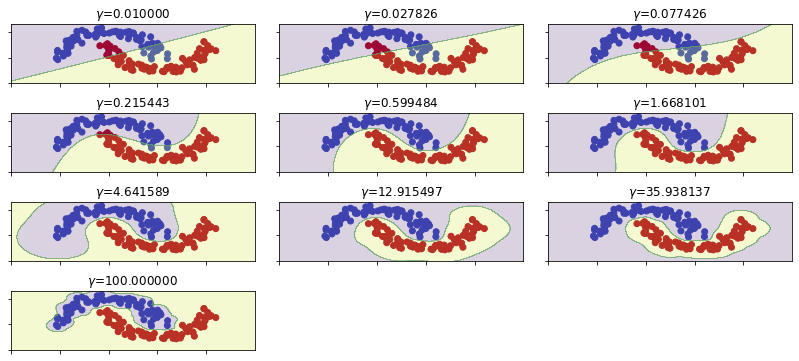

In [ ]:
h = 0.01
xrange = np.arange(-2, 3, h)
yrange = np.arange(-1, 1.3, h)
xx, yy = np.meshgrid(xrange, yrange)
zz = np.c_[xx.ravel(), yy.ravel()]

plt.figure(figsize=(14,6))
C = 10 
gammas = np.logspace(-2, 2, 10) # lo no lineal que vamos a hacer 
for n, gamma in enumerate(gammas):
    svc = SVC(kernel='rbf', gamma=gamma, C=C)
    svc.fit(Xtrain, ytrain)
    Z = svc.predict(zz)
    Z = Z.reshape(xx.shape)
    # Draw
    ax = plt.subplot(4, 3, n+1)
    plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm)
    plt.contourf(xx, yy, Z, alpha=0.2)
    plt.title(r'$\gamma$=%f' % gamma)
    plt.setp(ax, xticklabels=[], yticklabels=[])
plt.subplots_adjust(wspace=0.1, hspace=0.5)    

## Ejercicio
Repite el apartado anterior fijando $\gamma$ y variando C.

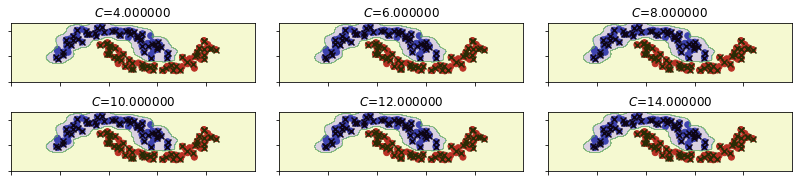

In [ ]:
h = 0.01
xrange = np.arange(-2, 3, h)
yrange = np.arange(-1, 1.3, h)
xx, yy = np.meshgrid(xrange, yrange)
# Puntos que cubren todo el espacio, prediciendo en cada uno de ellos. Mirando si es una clase u otra.
zz = np.c_[xx.ravel(), yy.ravel()] 

plt.figure(figsize=(14,6))

# C, paramentro que ajusta el modelo. Permite cierta libertad a cometer errores:
C = [4,6,8,10,12,14] # fijamos un valor de c, jugando con la gamma
gammas = 1 # lo no lineal que vamos a hacer.

# A mayor gamma ajustamos el espacio de las clases, indirectamente a través de kernel.
#1.6 es la buena porque los últimos valores ya estan sobreajustados. No nos serviría con ddatos nuevos. 
for n, C in enumerate(C):
    svc = SVC(kernel='rbf', gamma=gamma, C=C)
    svc.fit(Xtrain, ytrain)
    Z = svc.predict(zz)
    Z = Z.reshape(xx.shape)
    # Draw
    ax = plt.subplot(4, 3, n+1)
    plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm)
    plt.scatter(svc.support_vectors_[:,0],svc.support_vectors_[:,1], c= "black", marker = "x", label = "SVs")
    plt.contourf(xx, yy, Z, alpha=0.2)
    plt.title(r'$C$=%f' % C)
    plt.setp(ax, xticklabels=[], yticklabels=[])
plt.subplots_adjust(wspace=0.1, hspace=0.5)  

# Como influye c en la bondad de los parámetros.

## Escogiendo los hiperparámetros óptimos
Como acabamos de ver los parámetros libres de la SVM (también llamados hiperparámetros) son clave para el buen funcionamiento del algoritmo. La pregunta que sigue a continuación es lógicamente ¿cómo averiguamos cuáles son los mejores?

Hay varias formas de atacar el problema pero habitualmente se recurre a hacer un barrido donde probamos varios valores y nos quedamos con la mejor combinación. Aún así, ¿como fijamos el rango de valores a probar?

El parámetro C permite ajustar cuanto se penalizan los errores cometidos por el clasificador. Valores bajos de C permiten más errores, valores altos penalizan fuertemente los mismos. Valores demasiado bajos pueden provocar que se penalicen tan poco los errores que el modelo no se entrene correctamene. Por el contrario valores altos penalizan tanto los errores que provocan que el modelo se aprenda "de memoria" los datos, siendo incapaz de generalizar y predecir correctamene sobre datos no vistos (se produce un sobre-entrenamiento, u *overfitting*). En general podemos probar entre valores entre $10^{-3}$ y $10^3$.

## El "truco" para la escala del kernel RBF
En cuanto a la $\sigma$ del kernel RBF, para saber por donde empezar una técnica consiste en estimar la distancia media entre las muestras de entrenamiento. Dado que este kernel mide la distancia (o diferencia) entre muestras, $\|x_1-x_2\|^2$, es lógico utilizar un valor de $\sigma^2$ que esté en el mismo orden de magnitud. A partir de este valor empírico del valor de $\sigma^2$ se puede barrer en un rango de entre $10^{-2}$ o $10^{-1}$ y $10$ o $100$ veces este valor.

In [ ]:
# El truco de la sigma, viendo la expresión del kernel vemos que estamos calculando las distancias. 
# Entonces el valor de sigma estaría guay que estaría en el mismo orden de magnitud (de las distancias que estamos 
# intentando medir).

# pdist, le pasas una matriz de vectores y nos devuelve todas las distancias entre estos vectores. 
# Utilizar el de entrenamiento.
sigma_mean = np.mean(scipy.spatial.distance.pdist(Xtrain)) 

#Definomos un rango
sigma_min = sigma_mean * 0.1
sigma_max = sigma_mean * 10

### Recordemos que en scikit-learn en lugar de $\sigma$ tenemos $\gamma = \frac{1}{2\sigma^2}$

In [ ]:
# Pasamos de sigma a gamma
gamma_min = np.log10(1/2/sigma_max**2) #log, porque vamos a barrer un valores muy pequeños y amplis. Así tenemos un espacio muy grande
gamma_max = np.log10(1/2/sigma_min**2)

## Probando las diferentes combinaciones de parámetros
Determinar los rangos de parámetros a probar es el primer paso, pero ahora la cuestión es cómo probarlos adecuadamente.

Recordemos que solo tenemos un conjunto de entrenamiento, en nuestro caso `Xtrain` e `ytrain`, y que no debemos utilizar el conjunto de test para entrenar el modelo ya que este conjunto debe utilizarse únicamente para testear el modelo final.

Una opción podría ser entrenar con todo el conjunto de entrenamiento y validar sobre el mismo, pero haciendo esto corremos un alto riesgo de sobre-entrenar el modelo a los datos de entrenamiento, mermando sus capacidades de generalización.

Para evitar este problema vamos a subdividir de nuevo el conjunto de entrenamiento para disponer de conjuntos de entrenamiento y validación separados para evaluar el rendimiento de cada combinación de hiperparámetros. Podemos usar cualquiera de la técnicas vistas en la práctica anterior, *hold-out*, *k-fold*, etc. Para este ejemplo usaremos *k-fold* con $k=3$.

*Nota importante: fíjate que en la práctica anterior usábamos las técnicas de división de conjuntos solamente para testear el modelo. En esta práctica vamos a usar hold-out para testear el modelo final (igual que en la práctica anterior) y k-fold para ajustar los parámetros libres.*

## Ejercicio: completa el siguiente código

In [ ]:
# Definimos los  rangos
npoints = 20 
gammas = np.logspace(gamma_min, gamma_max, npoints) 
Cs = np.logspace(-3, 3, 7) # Espacio logaritmico, por lo mismo comentado anterioremente. Utilizando solo 7 puntos.

# Definimos el k-fold
kfold = KFold(n_splits=3) # Vamos a ahcer solo tres particiones. 

# Vamos probando cada combinación en cada subconjunto de entrenamiento y test
accuracies = [] #Lista de 3X20X7. Encontrando la que mejor resultados ha obtenido. 
n = 1
for itrain, itest in kfold.split(Xtrain):
    print('kfold %d ...' % n)
    n += 1
    for gamma in gammas:
        for C in Cs:
            # Creamos el modelo
            svc = SVC(kernel='rbf', gamma=gamma, C=C)
            
            # Entrena usando Xtrain, ytrain y los índices itrain
            svc.fit(Xtrain[itrain,:], ytrain[itrain])
            
            # Predice y evalúa el resultado sobre Xtrain, ytrain y los índices itest
            # svc.predict(Xtrain[itrain,:])
            acc = svc.score(Xtrain[itrain,:], ytrain[itrain])
            
            accuracies.append(acc)

kfold 1 ...
kfold 2 ...
kfold 3 ...


In [ ]:
# Buscamos la combinación que nos haya proporcionado el mejor resultado
# en las pruebas
accuracies = np.array(accuracies).reshape((3, npoints, 7)) 

# Calculo la media en el eje 0, de los tres modelos que he entrenado cada vez. Para ver en promedio cua ha funcionado 
# mejor.
macc = np.mean(accuracies, axis=0) 

# Devuelva las cordenadas al mejor resultado.
idx = np.unravel_index(np.argmax(macc), macc.shape)

# Cogemos la mejor combinación que ha obtenido en las pruebas sistemáticas
best_gamma, best_C = gammas[idx[0]], Cs[idx[1]] 
print('Best gamma:', best_gamma, 'best C:', best_C, 'Higest accuracy:', macc[idx[0], idx[1]])

Best gamma: 0.1632740691334328 best C: 1000.0 Higest accuracy: 1.0


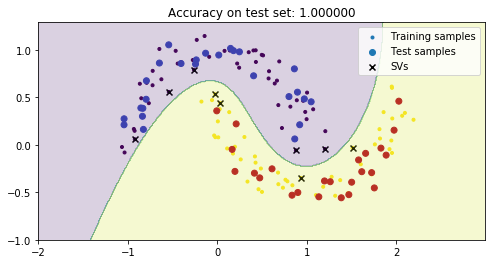

In [ ]:
# Train the final model using the best gamma and C combo
svc = SVC(kernel='rbf', gamma=best_gamma, C=best_C)
svc.fit(Xtrain, ytrain)
# Accuracy on test set
acc = svc.score(Xtest, ytest)
# Represent
Z = svc.predict(zz).reshape(xx.shape)
plt.figure(figsize=(8,4))
plt.scatter(Xtrain[:,0], Xtrain[:,1], c=ytrain, marker='.', label='Training samples')
plt.scatter(Xtest[:,0], Xtest[:,1], c=ytest, marker='o', cmap=plt.cm.coolwarm, label='Test samples')
plt.scatter(svc.support_vectors_[:,0], svc.support_vectors_[:,1], c='black', marker='x', label='SVs')
plt.contourf(xx, yy, Z, alpha=0.2)
plt.legend(), plt.title('Accuracy on test set: %f' % acc); # Nos da el porcentaje de "cuánto de bien" se ha hecho.

# Problemas de clasficación de más de dos clases
La SVM es por naturaleza un clasificador binario, define el hiperplano (la frontera) que separa dos clases. Para resolver problemas donde tenemos que clasificar más de dos clases se recurre principalmente a dos estrategias:

1. OVR (one-vs-rest), o uno contra el resto. Aquí lo que se hace es entrenar una clasificador para cada clase existente y efrentarlo contra el resto de clases agrupadas. Para predecir se pasa la muestra a clasificar por cada uno de los modelos entreandos y se le asigna la clase que obtiene más votos.

2. OVO (one-vs-other), o uno contra otro. Aquí si tenemos $C$ clases entrenamos $C(C-1)/2$ modelos que deciden entre cada par de clases. Para predecir usamos todos los modelos entrenados y de nuevo se escoge la clase más votada.

## Pregunta: enumera las ventajas e incovenientes que crees que tienen las estrategias OVR y OVO.

En la literatura existen trabajos donde se muestra que no existen diferencias significativas en los resultados obtenidos mediante estas dos estrategias (ver https://www.csie.ntu.edu.tw/~cjlin/papers/multisvm.pdf).

Por defecto las SVM de scikit-learn usan OVR, aunque os aconsejamos leer siempre la documentación porque esto puede cambiar.

## Para ilustrar el problema multiclase vamos a trabajar de nuevo con el dataset IRIS y probaremos la estrategia OVR

In [ ]:
X, y = load_iris(return_X_y=True) # Cambiamos el conjunto de datos, a más de dos clases.

## Ejercicio
Reduce la dimensionalidad de las $X$ a solo dos componentes mediante la PCA

In [ ]:
from sklearn import decomposition
# Define Xt como resultado de aplicar PCA sobre X
model_pca = decomposition.PCA(n_components=2)
model_pca.fit(X)
Xt = model_pca.transform(X)

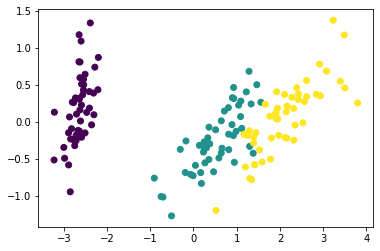

In [ ]:
# Mostramos las clases en el espacio PCA (Xt)
plt.scatter(Xt[:,0], Xt[:,1], c=y);

In [ ]:
#Dividimos conjunto de entrenamiento
Xtrain, Xtest, ytrain, ytest = train_test_split(Xt, y, test_size=1/3)

## GridSearchCV
Para entrenar los modelos vamos a recurrir de nuevo al k-fold, pero esta vez utilizaremos la función `GridSearchCV` de scikit-learn para automatizar el proceso.

Esta función toma un modelo de scikit-learn y un conjunto de parámetros y automáticamente realiza el proceso de ajuste de los mismos utilizando un k-fold. Parámetros relevantes:
- El modelo a entrenar.
- El grid de parámetros a utilizar.
- `cv`: en número $k$ de *folds* a usar. Usaremos 3.
- `verbose`: para que proporcione más o menos información.
- `n_jobs`: número de suprocesos a utilizar para entrenar. Esto disminuye muy significativamente el tiempo de entrenamiento necesario en sistemas con varios procesadores.

In [ ]:
# Creamos los tres modelos necesarios para implementar el OVR
sigma_mean = np.mean(scipy.spatial.distance.pdist(Xt))
gamma_mean = 1/2/sigma_mean**2
param_grid = [{
    'C': np.logspace(-3, 3, 7),
    'gamma': np.logspace(np.log10(gamma_mean*0.1), np.log10(gamma_mean*10), 20),
    'kernel': ['rbf']
}]
# Internamente cogen una SVC y la va a entrenar en ese rango de parámentros.
gcv1 = GridSearchCV(SVC(), param_grid=param_grid, cv=3, verbose=1, n_jobs=2)
gcv2 = GridSearchCV(SVC(), param_grid=param_grid, cv=3, verbose=0, n_jobs=2)
gcv3 = GridSearchCV(SVC(), param_grid=param_grid, cv=3, verbose=0, n_jobs=2)

## Ejercicio
Entrena los clasificadores gcv1, gcv2 y gcv3 para los clases 0 y 1, 0 y 2, y 1 y 3, respectivamente.

In [ ]:
# Classes 0 and 1
idx1 = ytrain != 2
gcv2.fit(Xtrain[idx2,:], ytrain[idx2])

GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+....e+02, 1.e+03]),
                          'gamma': array([0.00817026, 0.01041116, 0.01326668, 0.0169054 , 0.02154213,
       0.02745059, 0.0349796 , 0.04457363, 0.05679906, 0.07237763,
       0.092229  , 0.11752511, 0.14975931, 0.19083454, 0.24317568,
       0.30987268, 0.39486301, 0.50316405, 0.64116937, 0.81702609]),
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
    

In [ ]:
# Classes 0 and 2
idx2 = ytrain != 1
gcv2.fit(Xtrain[idx2,:], ytrain[idx2])

GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+....e+02, 1.e+03]),
                          'gamma': array([0.00817026, 0.01041116, 0.01326668, 0.0169054 , 0.02154213,
       0.02745059, 0.0349796 , 0.04457363, 0.05679906, 0.07237763,
       0.092229  , 0.11752511, 0.14975931, 0.19083454, 0.24317568,
       0.30987268, 0.39486301, 0.50316405, 0.64116937, 0.81702609]),
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
    

In [ ]:
# Classes 1 and 2
idx3 = ytrain != 1
gcv3.fit(Xtrain[idx3,:], ytrain[idx3])

GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+....e+02, 1.e+03]),
                          'gamma': array([0.00817026, 0.01041116, 0.01326668, 0.0169054 , 0.02154213,
       0.02745059, 0.0349796 , 0.04457363, 0.05679906, 0.07237763,
       0.092229  , 0.11752511, 0.14975931, 0.19083454, 0.24317568,
       0.30987268, 0.39486301, 0.50316405, 0.64116937, 0.81702609]),
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
    

## Ejercicio
Obtén las predicciones del conjunto de test (`Xtest`) en los tres modelos entrenados

## Ejercicio:
- Utilizando scipy.stats.mode (la moda) obtén la clase más votada
- Calcula y muestra el número de aciertos en % (accuracy)

## Comparación con OVR de scikit-learn
Por defecto las SVC de scikit-learn implemtan la estrategia OVR.

In [ ]:
# SVC already performs OVR (one-vs-rest) or OVO (one-vs-one) for you
param_grid = [{
    'C': np.logspace(-3, 3, 7),
    'gamma': np.logspace(np.log10(gamma_mean*0.1), np.log10(gamma_mean*10), 20),
    'kernel': ['rbf'],
    'decision_function_shape': ['ovr']
}]
gcv = GridSearchCV(SVC(), param_grid=param_grid, cv=3, verbose=1, n_jobs=2)

In [ ]:
gcv.fit(Xtrain, ytrain)

Fitting 3 folds for each of 140 candidates, totalling 420 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 420 out of 420 | elapsed:    0.2s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=2,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+...
                          'decision_function_shape': ['ovr'],
                          'gamma': array([0.00817026, 0.01041116, 0.01326668, 0.0169054 , 0.02154213,
       0.02745059, 0.0349796 , 0.04457363, 0.05679906, 0.07237763,
       0.092229  , 0.11752511, 0.14975931, 0.19083454, 0.24317568,
       0.30987268, 0.39486301, 0.50316405, 0.64116937, 0.81702609]),
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_job

In [ ]:
gcv.score(Xtest, ytest)

0.98

## Ejercicio
Representa las fronteras de separación para el problema multiclase

## Ejercicio opcional
- Prueba a implementar la estrategia OVR para el problema de 3 clases.
- Compara tus resultados con la SVC usando `decision_function_shape='ovr'`.